# Machine Learning éthique

Ce notebook est inspiré de l'article [FairTest: Discovering Unwarranted Associations in Data-Driven Applications](https://arxiv.org/abs/1510.02377) et propose d'étudier une façon de vérifier qu'un modèle ou une métrique n'est pas biaisé par rapport à certains critères.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Principe

Un problème de machine learning dans sa définition la plus simple consiste à prédire $Y$ en fonction de $I$. On souhaite construire une fonction $f(I)$ qui s'approche le plus possible de $Y$. On appelle $I$ l'ensemble des données utilisateurs ou *user input* et $f(I)$ la sortie du modèle ou *output to users (O)*. On veut découvrir si la sortie du modèle est biaisée d'une façon non-éthique par rapport à des attributs dits protégés ou *protected attributes (S)* tels que l'origine éthnique ou le genre. On tient compte également du contexte, code postal, ...) ou *context attributes (X)* et de variables explicative ou *explanotory attributes (E)*. On a donc :

* **I** : les variables en entrée du modèles,
* **O** : la prédiction du modèle,
* **S** : les attributs protégés, toute corrélation entre la sortie et ces attributs est indésirable,
* **X** : le contexte (principalement le lieu géographique)
* **E** : les variables explicatives (contraintes qualitification), la sortie est a priori corrélée avec ces attributs, de façon quasi prévisible mais cela reste éthique.

Un exemple. Supposons qu'on cherche à recommander un objet à la vente sur un site internet à partir des données de navigation de cette personne (I). Comme cette personne est identifiée, on peut savoir où elle habite (X), son origine éthnique (S) et son niveau d'étude (E). Le site lui recommande un livre de mathématiques (O). Est-ce que cette recommandation dépend principalement de l'origine éthnique (S) ? Et si les deux informations semblent corrélées, ne serait-ce pas plutôt son niveau d'étude (E) qui explique la recommandation ?

Concrètement, la sortie *O* ne dépend que de *I* mais on souhaite savoir si *I* ne serait pas corrélées à certains facteurs qui ne sont pas éthique. C'est une corrélation inattendue mais observable. Le contexte *X* permet de partitionner et de vérifier si le modèle est éthique sur l'ensemble des sous-groupes de population. Le processus de recherche des corrélations indésirées s'effectue en cinq temps.

* On choisit un attribut protégé $S_i$ et on réalise une partition de la population pour cet attribut.
* On vérifie pour chaque sous-population (ou chaque partie) que la sortie *O* et l'attribut $S_i$ ne sont pas corrélés. C'est l'étape de **détection**.
* Pour chaque biais détecté, on vérifie qu'il ne peut être expliqué par une des variables explicatrice auquel ce biais est acceptable. C'est l'étape de **debugging**.

In [2]:
%matplotlib inline

## Installation de FairTest

Le module ne peut pas être installé tel quel car il a été implémenté pour Python 2. Voici un lien qui devrait vous permettre de l'installer pour Python 3 si vous ne l'avez pas déjà fait.

In [3]:
# !pip install https://github.com/sdpython/fairtest/releases/download/0.1/fairtest-0.1-py3-none-any.whl

## Données

On récupère les données [adult](https://archive.ics.uci.edu/ml/datasets/Adult) pour lequel il faut prédire le fait qu'une personne ait un revenu supérieur à 50.000 dollars par an.

In [4]:
import pyensae.datasource as ds
data = ds.download_data("adult.data",
                        url="https://archive.ics.uci.edu/ml/machine-learning-databases/adult/")
names = ("age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,"
         "race,sexe,capital-gain,capital-loss,hours-per-week,native-country,income").split(",")

In [5]:
import pandas
df = pandas.read_csv(data, names=names)
df.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race     sexe  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

## Exemple avec aequitas

[aequitas](https://github.com/dssg/aequitas) propose un ensemble de métrique pour mesurer les biais éthiques.

In [6]:
from sklearn.model_selection import train_test_split
df2 = df.copy()
df2_train, df2_test = train_test_split(df2)

In [7]:
import numpy
label = "income"
X_train = df2_train.drop(label, axis=1)
y_train = df2_train[label] == ' >50K'
y_train = pandas.Series(numpy.array([1.0 if y else 0.0 for y in y_train]))
X_test = df2_test.drop(label, axis=1)
y_test = df2_test[label] == ' >50K'
y_test = pandas.Series(numpy.array([1.0 if y else 0.0 for y in y_test]))

In [8]:
X_train = X_train.drop(['fnlwgt'], axis=1).copy()
X_test = X_test.drop(['fnlwgt'], axis=1).copy()

In [9]:
cat_col = list(_ for _ in X_train.select_dtypes("object").columns)
cat_col

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sexe',
 'native-country']

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



pipe = make_pipeline(
            OneHotEncoder(handle_unknown="ignore"),
            DecisionTreeClassifier(min_samples_leaf=10))
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(categories='auto', drop=None,
                               dtype=<class 'numpy.float64'>,
                               handle_unknown='ignore', sparse=True)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features=None, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=10,
                                        min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        presort='deprecated', random_state=None,
                                        splitter='best'))],
         verbo

In [11]:
data = X_test.copy().reset_index(drop=True)
data["score"] = pipe.predict_proba(X_test)[:, 1]
data["label_value"] = y_test
data.head(n=4)

age workclass      education  education-num       marital-status  \
0   38   Private   Some-college             10            Separated   
1   18   Private        HS-grad              9        Never-married   
2   44   Private   Some-college             10   Married-civ-spouse   
3   34   Private        HS-grad              9   Married-civ-spouse   

       occupation    relationship    race     sexe  capital-gain  \
0   Other-service   Not-in-family   White   Female          4650   
1           Sales       Own-child   White     Male             0   
2    Craft-repair         Husband   White     Male             0   
3    Craft-repair         Husband   White     Male             0   

   capital-loss  hours-per-week  native-country     score  label_value  
0             0              72   United-States  0.000000          0.0  
1             0              20   United-States  0.000000          0.0  
2             0              60   United-States  0.500000          1.0  
3             0              40   United-States  0.333333          0.0

In [12]:
data_small = data[["sexe", "education", "score", "label_value"]].copy()
data_small.head(n=5)

sexe      education     score  label_value
0   Female   Some-college  0.000000          0.0
1     Male        HS-grad  0.000000          0.0
2     Male   Some-college  0.500000          1.0
3     Male        HS-grad  0.333333          0.0
4     Male        HS-grad  0.000000          0.0

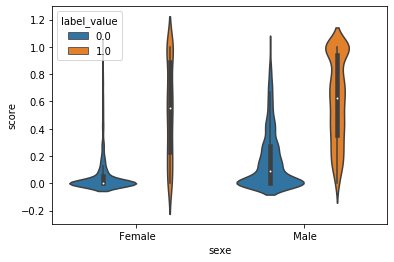

In [13]:
from seaborn import catplot, violinplot
g = violinplot(x="sexe", y="score", hue="label_value", data=data_small)

In [14]:
from aequitas.group import Group
g = Group()
xtab, _ = g.get_crosstabs(data_small)

model_id, score_thresholds 1 {'rank_abs': [472]}


In [15]:
xtab

model_id score_threshold    k attribute_name attribute_value       tpr  \
0          1      binary 0/1  472           sexe          Female  0.230769   
1          1      binary 0/1  472           sexe            Male  0.243094   
2          1      binary 0/1  472      education            10th  0.181818   
3          1      binary 0/1  472      education            11th  0.222222   
4          1      binary 0/1  472      education            12th  0.272727   
5          1      binary 0/1  472      education         1st-4th  0.000000   
6          1      binary 0/1  472      education         5th-6th  0.000000   
7          1      binary 0/1  472      education         7th-8th  0.100000   
8          1      binary 0/1  472      education             9th  0.000000   
9          1      binary 0/1  472      education      Assoc-acdm  0.250000   
10         1      binary 0/1  472      education       Assoc-voc  0.185185   
11         1      binary 0/1  472      education       Bachelors  0.284173   
12         1      binary 0/1  472      education       Doctorate  0.266667   
13         1      binary 0/1  472      education         HS-grad  0.165394   
14         1      binary 0/1  472      education         Masters  0.317391   
15         1      binary 0/1  472      education       Preschool       NaN   
16         1      binary 0/1  472      education     Prof-school  0.417476   
17         1      binary 0/1  472      education    Some-college  0.179837   

         tnr       for       fdr       fpr  ...     pprev  fp    fn    tn  \
0   0.999184  0.085821  0.028169  0.000816  ...  0.025809   2   230  2450   
1   0.998671  0.247144  0.012469  0.001329  ...  0.074397   5  1233  3756   
2   1.000000  0.037975  0.000000  0.000000  ...  0.008368   0     9   228   
3   1.000000  0.043210  0.000000  0.000000  ...  0.012195   0    14   310   
4   1.000000  0.085106  0.000000  0.000000  ...  0.030928   0     8    86   
5   1.000000  0.068182       NaN  0.000000  ...  0.000000   0     3    41   
6   1.000000  0.040816       NaN  0.000000  ...  0.000000   0     4    94   
7   1.000000  0.056250  0.000000  0.000000  ...  0.006211   0     9   151   
8   1.000000  0.045802       NaN  0.000000  ...  0.000000   0     6   125   
9   1.000000  0.193966  0.000000  0.000000  ...  0.060729   0    45   187   
10  1.000000  0.217105  0.000000  0.000000  ...  0.047022   0    66   238   
11  0.998729  0.336149  0.006289  0.001271  ...  0.118392   1   398   786   
12  0.950000  0.743243  0.047619  0.050000  ...  0.221053   1    55    19   
13  0.999557  0.126837  0.015152  0.000443  ...  0.024887   1   328  2258   
14  0.984536  0.451149  0.039474  0.015464  ...  0.179245   3   157   191   
15  1.000000  0.000000       NaN  0.000000  ...  0.000000   0     0    17   
16  0.971429  0.638298  0.022727  0.028571  ...  0.318841   1    60    34   
17  1.000000  0.172790  0.000000  0.000000  ...  0.036504   0   301  1441   

     tp  group_label_pos  group_label_neg  group_size  total_entities  \
0    69              299             2452        2751            8141   
1   396             1629             3761        5390            8141   
2     2               11              228         239            8141   
3     4               18              310         328            8141   
4     3               11               86          97            8141   
5     0                3               41          44            8141   
6     0                4               94          98            8141   
7     1               10              151         161            8141   
8     0                6              125         131            8141   
9    15               60              187         247            8141   
10   15               81              238         319            8141   
11  158              556              787        1343            8141   
12   20               75               20          95            8141   
13   65              393           

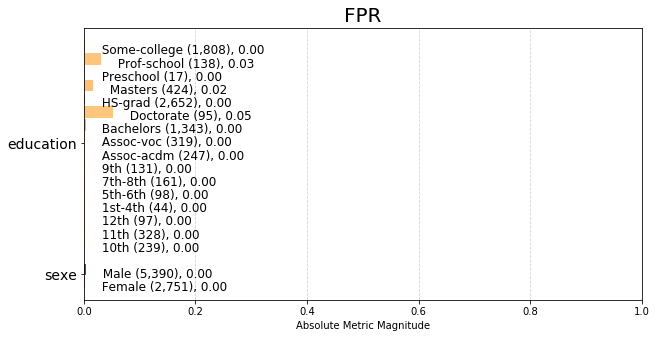

In [16]:
from aequitas.plotting import Plot

aqp = Plot()
fpr_plot = aqp.plot_group_metric(xtab, 'fpr')

In [17]:
set(data_small['education'])

{' 10th',
 ' 11th',
 ' 12th',
 ' 1st-4th',
 ' 5th-6th',
 ' 7th-8th',
 ' 9th',
 ' Assoc-acdm',
 ' Assoc-voc',
 ' Bachelors',
 ' Doctorate',
 ' HS-grad',
 ' Masters',
 ' Preschool',
 ' Prof-school',
 ' Some-college'}

In [18]:
from aequitas.bias import Bias

b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, 
                    original_df=data_small, 
                    ref_groups_dict={'sexe': ' Male', 'education':' Masters'},
                    alpha=0.05, 
                    check_significance=False)

get_disparity_predefined_group()


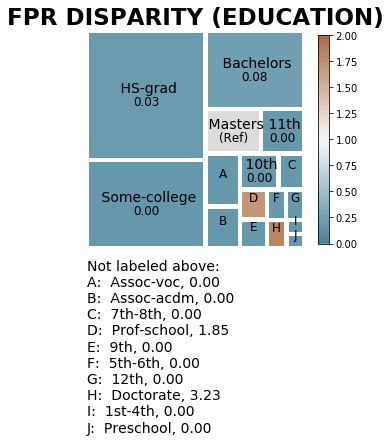

In [19]:
 fpr_disparity = aqp.plot_disparity(bdf, group_metric='fpr_disparity', 
                                    attribute_name='education')

## Exemple avec fairtest

Ne fonctionne pas encore. Il faut passer à Python trois.

In [20]:
try:
    from fairtest import DataSource
    cont = True
except ImportError:
    cont = False
# On prend les 1000 premières lignes.
# Le processus est assez long.
if cont:
    dsdat = DataSource(df[:1000], budget=1, conf=0.95)

In [21]:
if cont:
    from fairtest import Testing, train, test, report

    SENS = ['sex', 'race']     # Protected features
    TARGET = 'income'             # Output
    EXPL = ''                     # Explanatory feature

    inv = Testing(dsdat, SENS, TARGET, EXPL)
    train([inv])

In [22]:
if cont:
    test([inv])

In [23]:
if cont:
    try:
        report([inv], "adult")
    except Exception as e:
        print("ERROR")
        print(e)
        # à corriger encore

## Exercice 1 : Construire un arbre de décision avec son propre critère

On pourra s'inspirer de l'article [Pure Python Decision Trees](http://kldavenport.com/pure-python-decision-trees/),
ou [How To Implement The Decision Tree Algorithm From Scratch In Python](https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/). Cet arbre de décision doit produire un résultat similaire à ceci : [Contexte-education-num-in-(9.5, 11.5)-age-in(46.5, inf)](https://github.com/sdpython/fairtest/blob/master/results/report_adult.txt#L35). Il s'agit d'implémenter l'algorithme qui suit avec la métrique [Mutual Information (MI)](https://fr.wikipedia.org/wiki/Information_mutuelle).

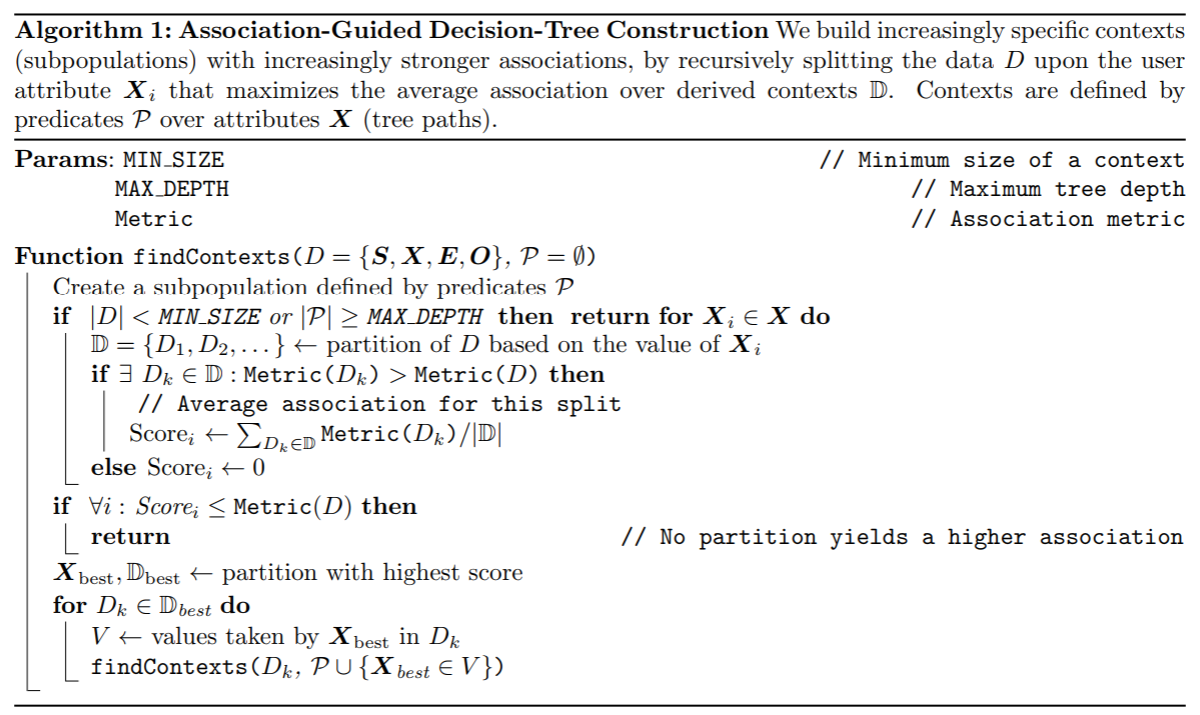

In [24]:
from pyquickhelper.helpgen import NbImage
NbImage("fairtesttree.png")

## Exercice 2 : appliquer l'algorithme sur le jeu de données adulte

## Exercice 3 : apprendre sans interactions

In [27]:
df2 = df.copy()
df2["un"] = 1
df2["age10"] = (df["age"] // 10) * 10
gr = df2[["age10", "sexe", "income", "un"]].groupby(["age10", "sexe", "income"], as_index=False).sum()
gr.head()

age10     sexe  income    un
0     10   Female   <=50K   809
1     10   Female    >50K     1
2     10     Male   <=50K   846
3     10     Male    >50K     1
4     20   Female   <=50K  3048

In [28]:
g = gr.pivot_table("un", "age10", ["income", "sexe"])
g

income   <=50K            >50K        
sexe    Female    Male  Female    Male
age10                                 
10       809.0   846.0     1.0     1.0
20      3048.0  4497.0   128.0   381.0
30      2185.0  4119.0   391.0  1918.0
40      1778.0  2735.0   383.0  2279.0
50      1020.0  1691.0   207.0  1500.0
60       554.0   922.0    58.0   481.0
70       162.0   249.0     9.0    88.0
80        24.0    46.0     NaN     8.0
90        12.0    23.0     2.0     6.0

In [29]:
g.columns

MultiIndex([(' <=50K', ' Female'),
            (' <=50K',   ' Male'),
            ( ' >50K', ' Female'),
            ( ' >50K',   ' Male')],
           names=['income', 'sexe'])

In [30]:
g["rF"] = g[(" <=50K", " Female")] / g[(" >50K", " Female")]
g["rM"] = g[(" <=50K", " Male")] / g[(" >50K", " Male")]
g

income   <=50K            >50K                  rF          rM
sexe    Female    Male  Female    Male                        
age10                                                         
10       809.0   846.0     1.0     1.0  809.000000  846.000000
20      3048.0  4497.0   128.0   381.0   23.812500   11.803150
30      2185.0  4119.0   391.0  1918.0    5.588235    2.147550
40      1778.0  2735.0   383.0  2279.0    4.642298    1.200088
50      1020.0  1691.0   207.0  1500.0    4.927536    1.127333
60       554.0   922.0    58.0   481.0    9.551724    1.916840
70       162.0   249.0     9.0    88.0   18.000000    2.829545
80        24.0    46.0     NaN     8.0         NaN    5.750000
90        12.0    23.0     2.0     6.0    6.000000    3.833333

Les deux variables paraissent corrélées.

On apprend trois modèles :
    
* On prédit 'income' avec l'âge et le genre, modèle M0
* On prédit 'income' avec l'âge uniquement, modèle M1
* On prédit 'income' avec le genre uniquement, modèle M2
* On prédit 'income' avec les modèles M1 et M2.

Le modèle prédit-il aussi bien, moins bien ? Qu'en déduisez-vous ?